In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
output_dir = os.path.join(os.path.curdir, 'output') 

In [4]:
from bayesfilt import KalmanFilter, UnscentedKalmanFilter, ExtendedKalmanFilter
from bayesfilt import ConstantAccelerationND, LinearObservationModel

In [5]:
t = np.load(os.path.join(output_dir, 'tlist.npy'))
yobs = np.load(os.path.join(output_dir, 'yobs.npy'))
ytrue = np.load(os.path.join(output_dir, 'ytrue.npy'))

## CA

In [19]:
observed = {0:0, 1:3} # observation-state pairs of indices
truth = {0:0, 6:1, 8:2, 1:3, 5:4, 7:5} # truth-state pairs of indices
dt = 0.005
start_x = [yobs[0,0], 0.001, 0, yobs[1,0], 0.001, 0.]
start_P = np.diag([0.5]*6)
mm = ConstantAccelerationND(dof=2)
mm.update(dt = dt, sigmas = [2.]*2)
om = LinearObservationModel(nx=mm.nx, observed=observed)
om.update(sigmas=[0.1]*2)

## Kalman Filter

In [20]:
kf = KalmanFilter(nx=mm.nx, ny = om.ny, dt = dt)
kf.F = mm.F.copy()
kf.Q = mm.Q.copy()
kf.H = om.H.copy()
kf.R = om.R.copy()
kf.initiate_state(t[0], start_x, start_P)
kf.filter(t[1:], [ix for ix in yobs[:,1:].T])
kf.smoother()
print(kf.metrics)
print(kf.metrics_smoother)

{'nis': 1791.41, 'nees': 2206.781, 'loglik': -308.356}
{'nis': 595.093, 'nees': 72.297, 'loglik': 493.847}


## UKF

In [22]:
ukf = UnscentedKalmanFilter(nx=mm.nx, ny = om.ny, dt = dt)
ukf.f = mm.f
ukf.Q = mm.Q.copy()
ukf.h = om.h
ukf.R = om.R.copy()
ukf.initiate_state(t[0], start_x, start_P)
ukf.filter(t[1:], [ix for ix in yobs[:,1:].T])
ukf.smoother()
print(ukf.metrics)
print(ukf.metrics_smoother)

{'nis': 1791.41, 'nees': 2206.781, 'loglik': -308.356}
{'nis': 595.093, 'nees': 72.297, 'loglik': 493.847}


## EKF

In [24]:
ekf = ExtendedKalmanFilter(nx=mm.nx, ny = om.ny, dt = dt)
ekf.f = mm.f
ekf.compute_F = mm.compute_F
ekf.compute_G = mm.compute_G
ekf.compute_Q = mm.compute_Q
ekf.h = om.h
ekf.compute_H = om.compute_H
ekf.compute_J = om.compute_J
ekf.R = om.R.copy()
ekf.initiate_state(t[0], start_x, start_P)
ekf.filter(t[1:], [ix for ix in yobs[:,1:].T])
ekf.smoother()
print(ekf.metrics)
print(ekf.metrics_smoother)

{'nis': 1791.41, 'nees': 2206.781, 'loglik': -308.356}
{'nis': 491.384, 'nees': 147.638, 'loglik': 477.64}


In [25]:
print(kf.metrics == ekf.metrics)
print(kf.metrics == ukf.metrics)

True
True


## Compare

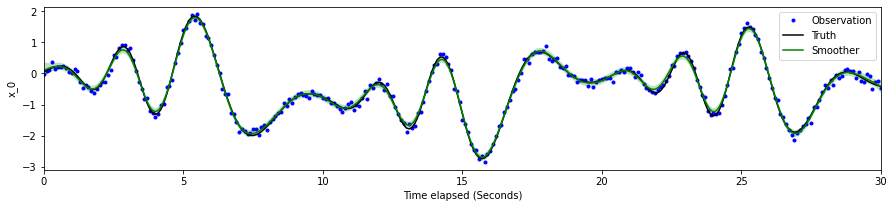

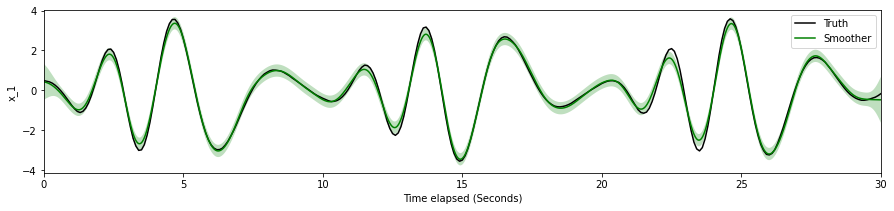

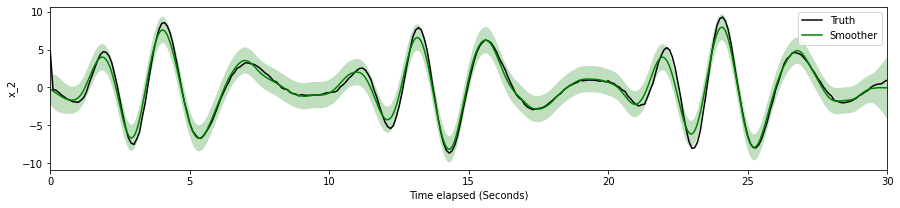

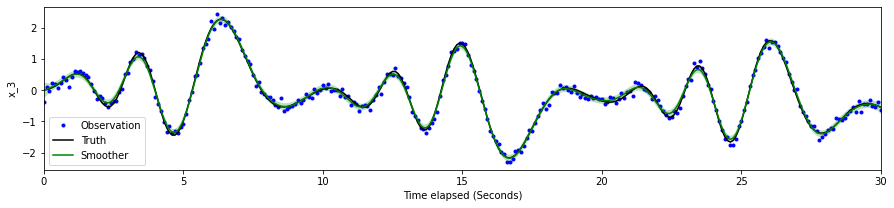

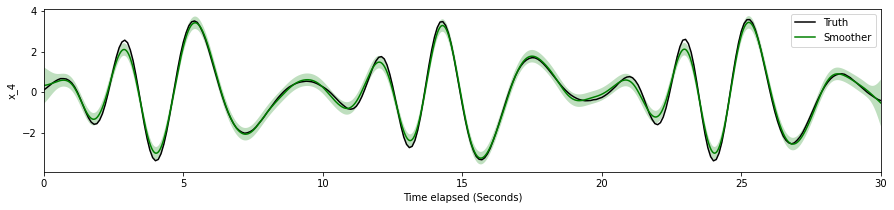

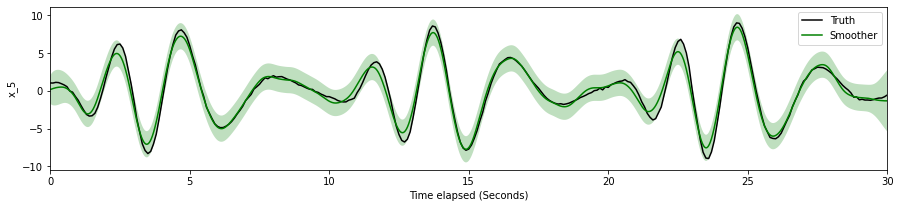

In [18]:
for i in range(mm.nx):
    fig, ax = plt.subplots(figsize=(15,3))
    for k, v in observed.items():
        if v == i:
            ax.plot(t, yobs[k,:], '.b', label='Observation')
    for k, v in truth.items():
        if v == i:
            ax.plot(t, ytrue[k,:], '-k', label='Truth')
    #kf.plot_state(ax, i, 'r', 'filter', linestyle='-', label='Filter')
    kf.plot_state(ax, i, 'g', 'smoother', linestyle='-', label='Smoother')
    #ax.set_xlim([20,40])
    ax.legend()

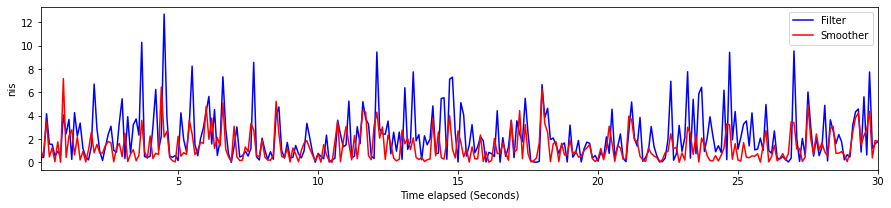

In [12]:
fig, ax = plt.subplots(figsize=(15,3))
mname = 'nis'
ekf.plot_metric(ax, mname, color='b', ftype='filter', label='Filter')
ekf.plot_metric(ax, mname, color='r', ftype='smoother', label='Smoother')
ax.legend()